In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout

import seaborn as sns

In [2]:
raw_data = pd.read_csv('./Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [3]:
raw_data.columns

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')

# Checking for empty data or NaN or Null values

In [4]:
raw_data.isnull().sum()

id                         0
dateAdded                  0
dateUpdated                0
name                       0
asins                      0
brand                      0
categories                 0
primaryCategories          0
imageURLs                  0
keys                       0
manufacturer               0
manufacturerNumber         0
reviews.date               0
reviews.dateSeen           0
reviews.didPurchase    28323
reviews.doRecommend    12246
reviews.id             28291
reviews.numHelpful     12217
reviews.rating             0
reviews.sourceURLs         0
reviews.text               0
reviews.title              0
reviews.username           0
sourceURLs                 0
dtype: int64

# removing unwanted datas

In [5]:
df = raw_data[['name','categories','reviews.text','reviews.title','reviews.rating']]

In [6]:
df.head(5)

,name,categories,reviews.text,reviews.title,reviews.rating
0,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,3
1,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,4
2,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,5
3,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,5
4,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,5


In [7]:
def remove_tag(string):
    text=re.sub('<.*?>','',string)
    return text
def remove_mention(text):
    line=re.sub(r'@\w+','',text)
    return line
def remove_hash(text):
    line=re.sub(r'#\w+','',text)
    return line

def remove_newline(string):
    text=re.sub('\n','',string)
    return text
def remove_url(string): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',string)
    return text
def remove_number(text):
    line=re.sub(r'[0-9]+','',text)
    return line
def remove_punct(text):
    line = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',text)
    #string="".join(line)
    return line
def text_strip(string):
    line=re.sub('\s{2,}', ' ', string.strip())
    return line
def remove_thi_amp_ha_words(string):
    line=re.sub(r'\bamp\b|\bthi\b|\bha\b',' ',string)
    return line

In [8]:
df['clean_review'] =  df['reviews.title'].str.lower()
df['clean_review'] = df['clean_review'].apply(lambda x:remove_tag(str(x)))
df['clean_review'] = df['clean_review'].apply(lambda x:remove_mention(str(x)))
df['clean_review'] = df['clean_review'].apply(lambda x:remove_hash(str(x)))
df['clean_review'] = df['clean_review'].apply(lambda x:remove_newline(x))
df['clean_review'] = df['clean_review'].apply(lambda x:remove_url(x))
df['clean_review'] = df['clean_review'].apply(lambda x:remove_number(x))
df['clean_review'] = df['clean_review'].apply(lambda x:remove_punct(x))
df['clean_review'] = df['clean_review'].apply(lambda x:remove_thi_amp_ha_words(x))
df['clean_review'] = df['clean_review'].apply(lambda x:text_strip(x))

df['text_length']=df['clean_review'].str.split().map(lambda x: len(x))

In [9]:
df.head(3)

,name,categories,reviews.text,reviews.title,reviews.rating,clean_review,text_length
0,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,3,of them and one of the item is bad quality is ...,17
1,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,4,always the less expensive way to go for produc...,10
2,AmazonBasics AAA Performance Alkaline Batterie...,"AA,AAA,Health,Electronics,Health & Household,C...",Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,5,are not duracell but for the price i am happy,10


In [10]:
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\riaz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\riaz\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
sentiment = SentimentIntensityAnalyzer()

In [12]:
def get_senti_score(text):
    score = sentiment.polarity_scores(text)
    return score["compound"]

In [13]:
df["s.score"] = df.clean_review.apply(lambda x: get_senti_score(x))

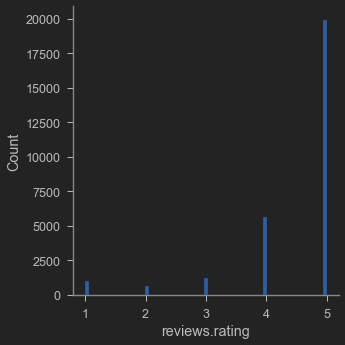

In [14]:
sns.displot(x=df['reviews.rating'])

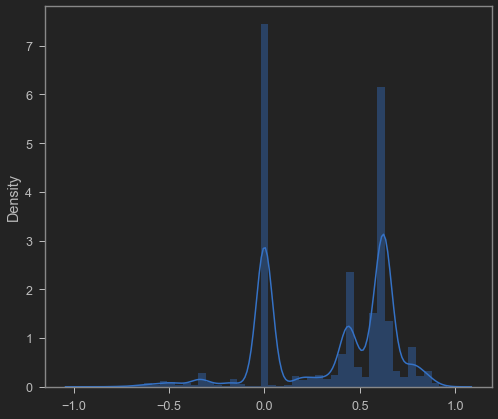

In [15]:
sns.distplot(x=df['s.score'])